# Deep Learning for Cone Cells and Light Frequency

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

np.set_printoptions(suppress=True)

import sklearn.metrics as metrics

import tensorflow as tf
from tensorflow import keras

import pickle

from simulator_lib import *

2025-04-24 23:51:33.208301: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-24 23:51:33.211766: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-24 23:51:33.221070: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745553093.236358    8958 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745553093.240719    8958 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-24 23:51:33.257017: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

## Generating / Loading the Cone Cells

In [ ]:
GENERATE_NEW_CONE_CELLS = False

NUM_EYES = 10
NUM_CELLS_PER_EYE = 10000

NUM_RED = int(NUM_CELLS_PER_EYE * PERCENT_RED)
NUM_GREEN = int(NUM_CELLS_PER_EYE * PERCENT_GREEN)
NUM_BLUE = int(NUM_CELLS_PER_EYE * PERCENT_BLUE)
assert(NUM_RED + NUM_GREEN + NUM_BLUE == NUM_CELLS_PER_EYE)

if GENERATE_NEW_CONE_CELLS:

    eyes = []

    for i in range(NUM_EYES):
        RED_MU = np.random.uniform(RED_MU_LOWER, RED_MU_UPPER)
        GREEN_MU = np.random.uniform(GREEN_MU_LOWER, GREEN_MU_UPPER)
        BLUE_MU = np.random.uniform(BLUE_MU_LOWER, BLUE_MU_UPPER)

        # create the cone cells
        cone_cells = (
            generate_cone_cells(NUM_RED, RED_MU, RED_SIGMA) +
            generate_cone_cells(NUM_GREEN, GREEN_MU, GREEN_SIGMA) +
            generate_cone_cells(NUM_BLUE, BLUE_MU, BLUE_SIGMA)
        )

        eyes.append(cone_cells)

        # save the cone cells
        with open(f"./data/normal_cone_cells/eye{i:02}.pkl", "wb") as fp:
            pickle.dump(cone_cells, fp, pickle.HIGHEST_PROTOCOL)

else:

    eyes = []

    for i in range(NUM_EYES):
        with open(f"./data/normal_cone_cells/eye{i:02}.pkl", mode="rb") as fp:
            cone_cells = pickle.load(fp)
            eyes.append(cone_cells)

## Generating the Simulation Data

In [12]:
NUM_DATA_POINTS = 1000
MIN_WAVELENGTH = 380
MAX_WAVELENGTH = 750

activations = np.zeros(shape=(len(eyes) * NUM_DATA_POINTS, len(eyes[0])))
colors = np.zeros(shape=(len(eyes) * NUM_DATA_POINTS))

for i, cone_cells in enumerate(eyes):
    a, c = sample_wavelengths(
        num_data_points=NUM_DATA_POINTS, 
        cells=cone_cells, 
        min_wl=MIN_WAVELENGTH, 
        max_wl=MAX_WAVELENGTH,
    )
    c = np.array(c).astype(int)

    activations[i * NUM_DATA_POINTS : (i+1) * NUM_DATA_POINTS] = a
    colors[i * NUM_DATA_POINTS : (i+1) * NUM_DATA_POINTS] = c

print(activations)
print(colors)

[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[1. 5. 4. ... 4. 5. 4.]


## Feedforward Network Architecture

### Separate Data into Training and Test Sets

In [ ]:
# shuffle the data
#randomize = np.arange(len(activations), dtype=int)
#np.random.shuffle(randomize)
#activations = activations[randomize]
#colors = colors[randomize]

PERCENT_TRAIN_SET = 0.8
NUM_TRAIN_SET = int(len(activations) * PERCENT_TRAIN_SET)

train_activations = activations[:NUM_TRAIN_SET]
train_colors = colors[:NUM_TRAIN_SET]
test_activations = activations[NUM_TRAIN_SET:]
test_colors = colors[NUM_TRAIN_SET:]

### Model Setup

In [14]:
model = keras.Sequential([
    keras.Input(shape=(train_activations.shape[-1], )),
    keras.layers.Dense(units=128, activation="silu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=128, activation="silu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=128, activation="silu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=128, activation="silu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=len(Color), activation="softmax"),
])

### Compile Model

In [15]:
optimizer = keras.optimizers.AdamW(learning_rate=5e-4, weight_decay=0.004)
model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 128)            │     1,280,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,330,438 (5.08 MB)

 Trainable params: 1,330,438 (5.08 MB)

 Non-trainable params: 0 (0.00 B)

### Fit the Model

In [16]:
EPOCHS = 10
h = model.fit(train_activations, train_colors, batch_size=64, epochs=EPOCHS, validation_split=0.1)

Epoch 1/10


2025-04-24 23:54:20.796996: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 306000000 exceeds 10% of free system memory.


120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.7877 - loss: 0.8571 - val_accuracy: 0.9753 - val_loss: 0.0967
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.9593 - loss: 0.1337 - val_accuracy: 0.9800 - val_loss: 0.0567
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9735 - loss: 0.0906 - val_accuracy: 0.9824 - val_loss: 0.0519
Epoch 4/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.9813 - loss: 0.0602 - val_accuracy: 0.9894 - val_loss: 0.0368
Epoch 5/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.9815 - loss: 0.0509 - val_accuracy: 0.9835 - val_loss: 0.0526
Epoch 6/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.9834 - loss: 0.0547 - val_accuracy: 0.9882 - val_loss: 0.0348
Epoch 7/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9825 - loss: 0.0551 - val_accuracy: 0.9906 - val_loss: 0.0274
Epoch 8/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.9881 - loss: 0.0360 - val_accuracy: 0.987

### Visualize Loss Trajectory

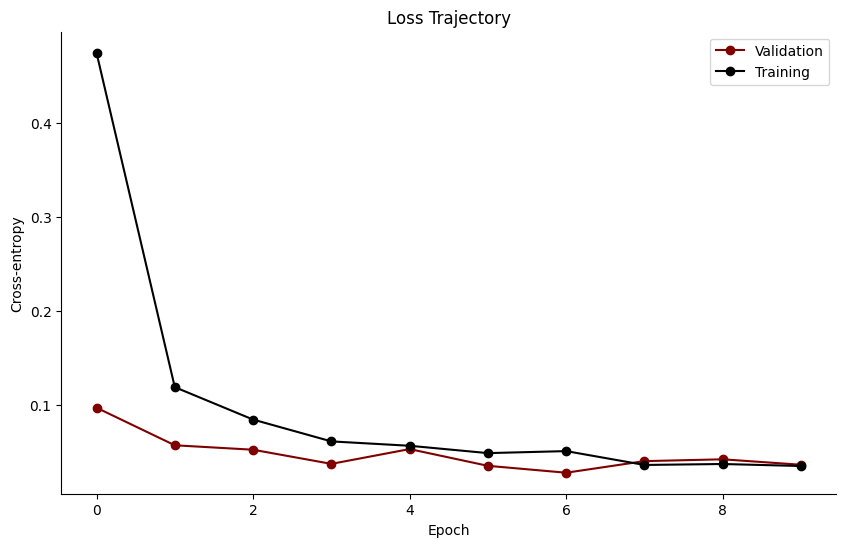

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(range(EPOCHS), h.history['val_loss'], 'o-', color='maroon', label='Validation')
ax.plot(range(EPOCHS), h.history['loss'], 'o-', color='black', label='Training')
ax.set_xlabel('Epoch')
ax.set_ylabel('Cross-entropy')
ax.legend()
ax.set_title('Loss Trajectory')
sns.despine(ax=ax)

### Evaluate Model on Test Data

In [ ]:
test_loss, test_accuracy = model.evaluate(test_activations, test_colors)

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9881 - loss: 0.0329
0.030849816277623177
0.9879999756813049


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


numpy.ndarray

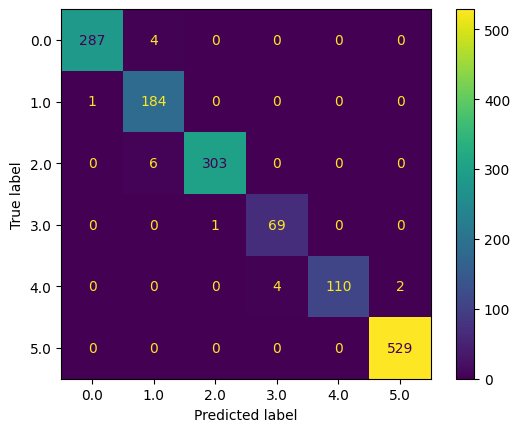

In [ ]:
preds = model.predict(test_activations)
metrics.ConfusionMatrixDisplay.from_predictions(test_colors, preds.argmax(axis=1))

## Testing on Data from Abnormal Eyes

### "Damanged" Eyes

"Damaged" eyes have a chance for some cells to be dead and never activate.

#### Generating / Loading the Cone Cells for "Damaged" Eyes

In [24]:
GENERATE_NEW_CONE_CELLS = False

NUM_EYES = 10
PROB_DEAD_CELL_STEP = 0.1

NUM_CELLS_PER_EYE = 10000

NUM_RED = int(NUM_CELLS_PER_EYE * PERCENT_RED)
NUM_GREEN = int(NUM_CELLS_PER_EYE * PERCENT_GREEN)
NUM_BLUE = int(NUM_CELLS_PER_EYE * PERCENT_BLUE)
assert(NUM_RED + NUM_GREEN + NUM_BLUE == NUM_CELLS_PER_EYE)

if GENERATE_NEW_CONE_CELLS:

    damaged_eyes = []

    for i in range(NUM_EYES):
        RED_MU = np.random.uniform(RED_MU_LOWER, RED_MU_UPPER)
        GREEN_MU = np.random.uniform(GREEN_MU_LOWER, GREEN_MU_UPPER)
        BLUE_MU = np.random.uniform(BLUE_MU_LOWER, BLUE_MU_UPPER)
        PROB_DEAD_CELL = i * PROB_DEAD_CELL_STEP

        # create the cone cells
        cone_cells = (
            generate_cone_cells(NUM_RED, RED_MU, RED_SIGMA, PROB_DEAD_CELL) +
            generate_cone_cells(NUM_GREEN, GREEN_MU, GREEN_SIGMA, PROB_DEAD_CELL) +
            generate_cone_cells(NUM_BLUE, BLUE_MU, BLUE_SIGMA, PROB_DEAD_CELL)
        )

        damaged_eyes.append(cone_cells)

        # save the cone cells
        with open(f"./data/damaged_cone_cells/eye{i:02}.pkl", "wb") as fp:
            pickle.dump(cone_cells, fp, pickle.HIGHEST_PROTOCOL)

else:

    damaged_eyes = []

    for i in range(NUM_EYES):
        with open(f"./data/damaged_cone_cells/eye{i:02}.pkl", mode="rb") as fp:
            cone_cells = pickle.load(fp)
            damaged_eyes.append(cone_cells)

#### Testing Model on "Damaged" Eyes

In [45]:
NUM_DATA_POINTS = 100
MIN_WAVELENGTH = 380
MAX_WAVELENGTH = 750

confusion_data = []
accuracies = []

for cone_cells in damaged_eyes:
    activations, colors = sample_wavelengths(
        num_data_points=NUM_DATA_POINTS, 
        cells=cone_cells, 
        min_wl=MIN_WAVELENGTH, 
        max_wl=MAX_WAVELENGTH,
    )
    colors = np.array(colors).astype(int)
    preds = model.predict(activations)
    confusion_data.append((colors, preds))
    _, accuracy = model.evaluate(activations, colors)
    accuracies.append(accuracy)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8547 - loss: 0.3970 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7390 - loss: 0.8515
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7233 - loss: 0.5996
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6605 - loss: 0.9403
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7807 - loss: 0.5022
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7484 - loss: 0.6352 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8063 - loss: 0.5029 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6750 - loss: 0.9194
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5292 - loss: 1.0430
4/4 ━━━━━━

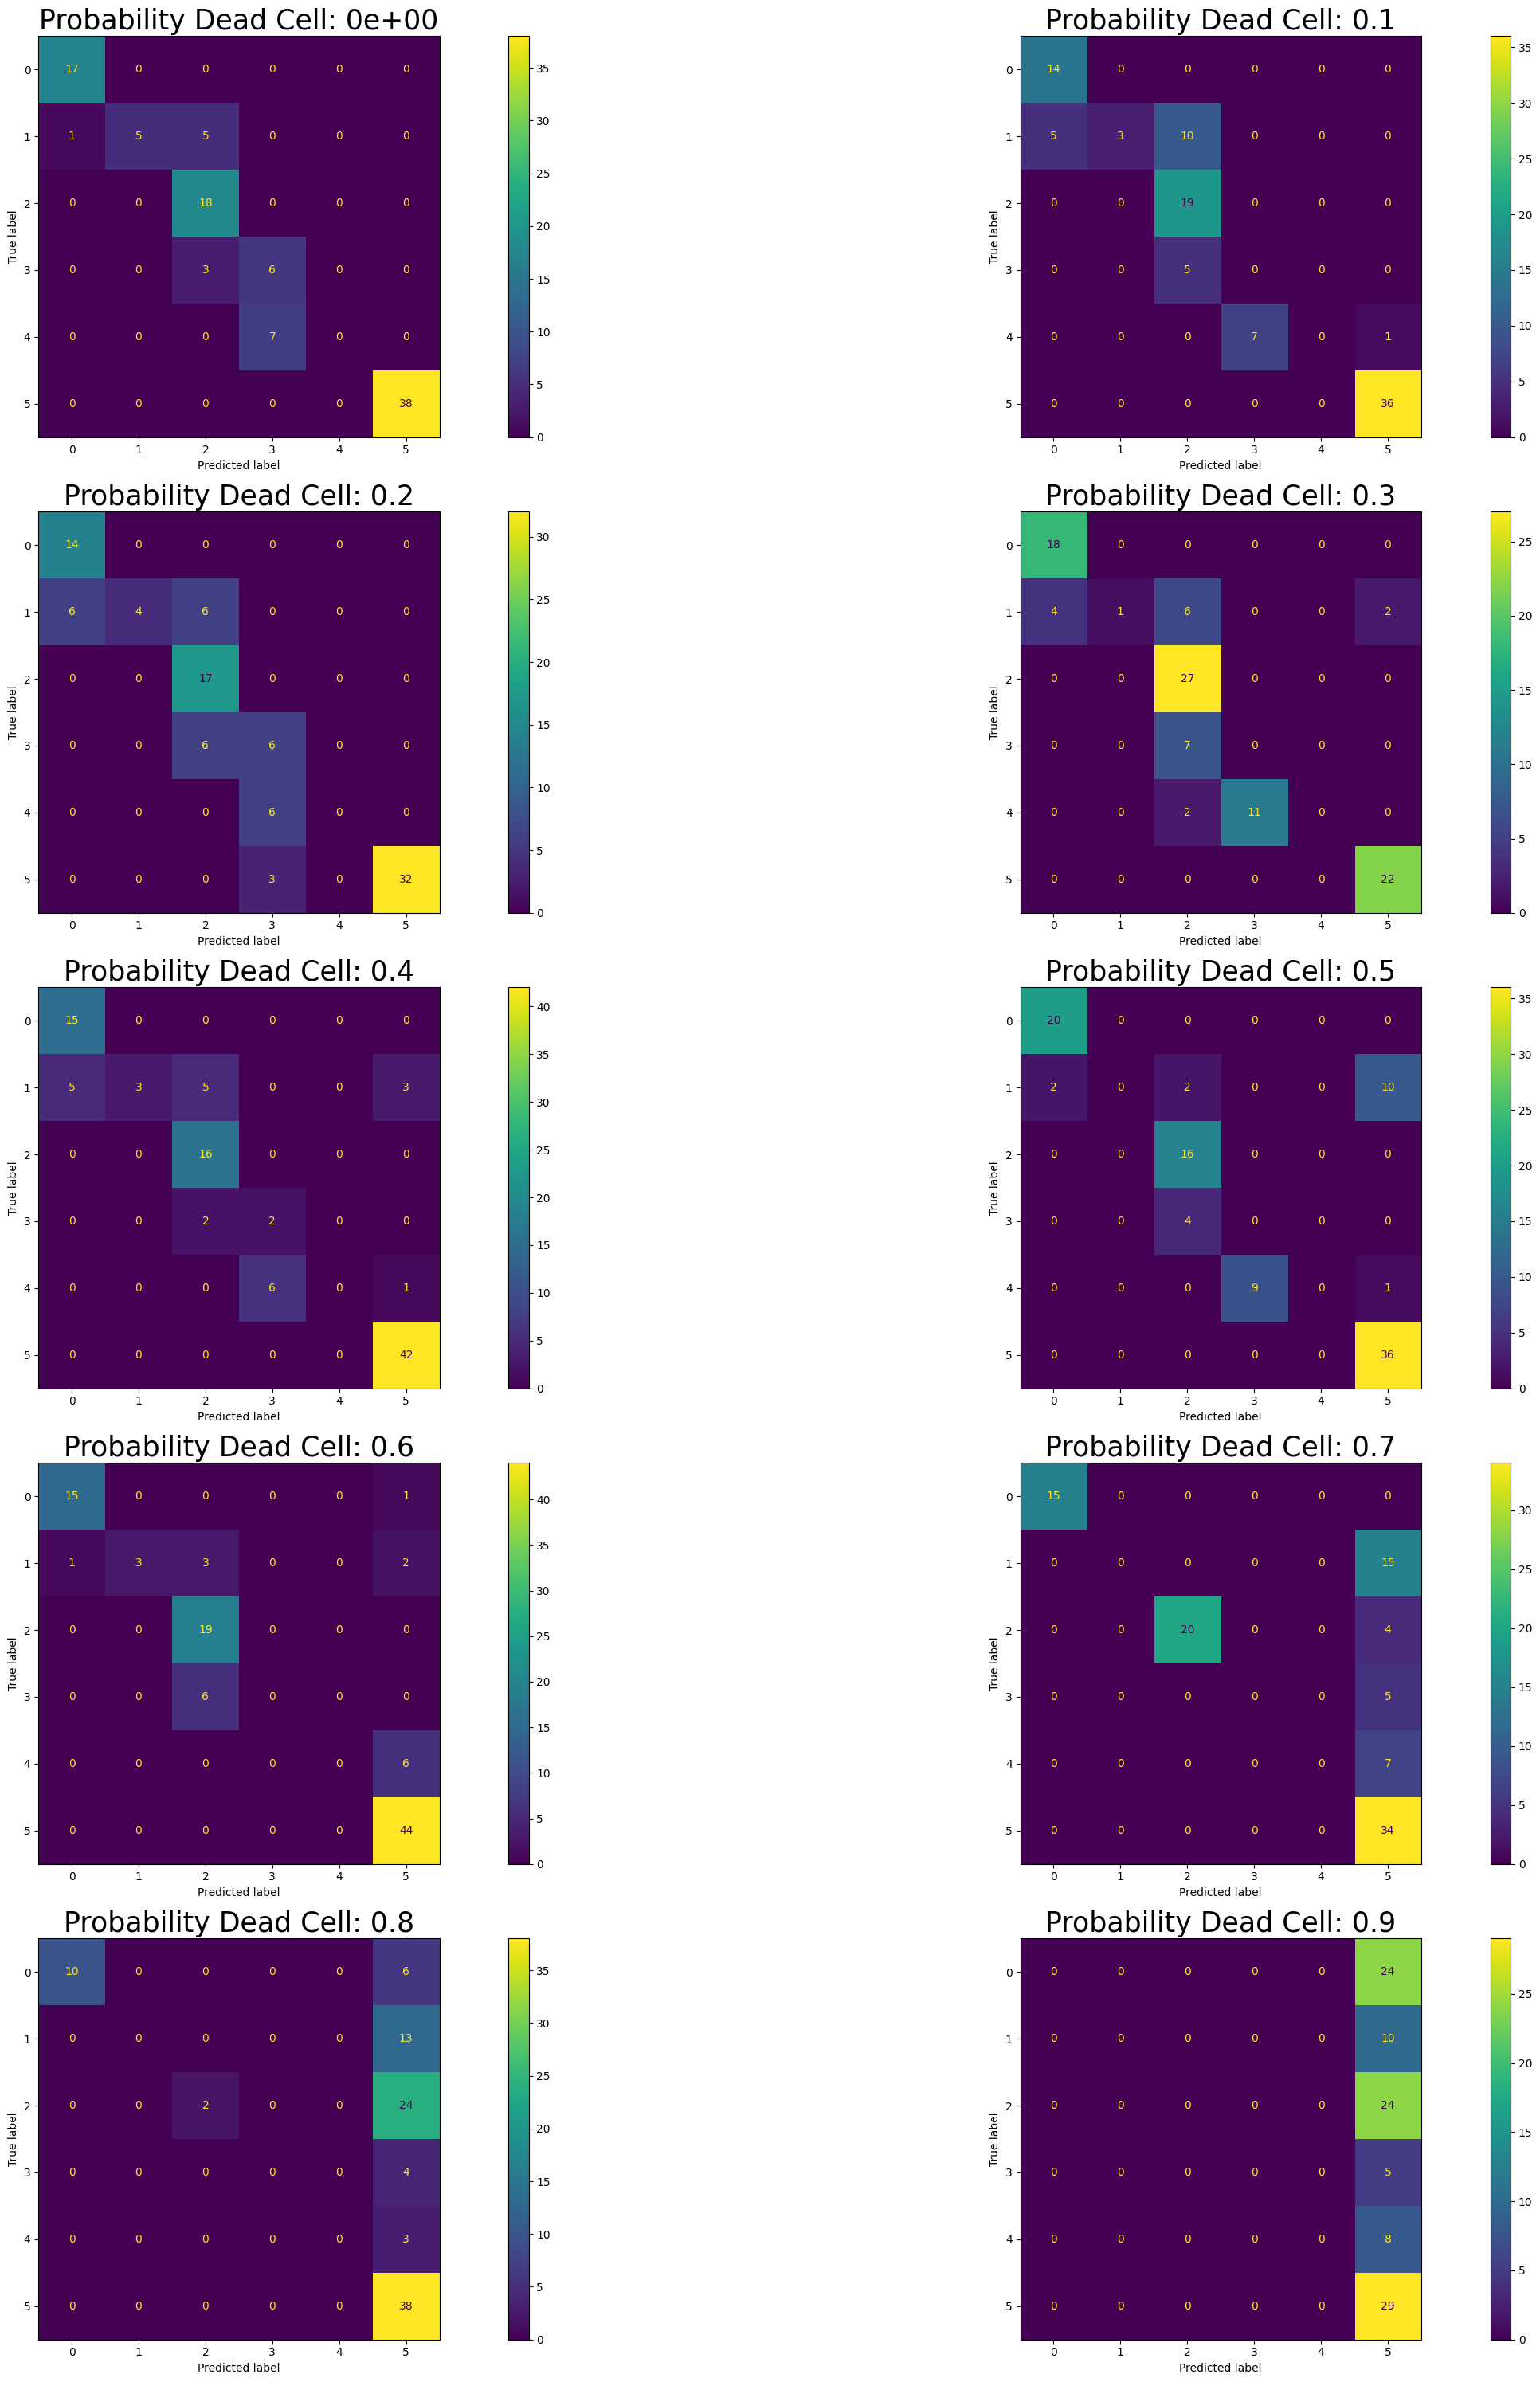

In [46]:
fig, axarr = plt.subplots(5, 2, figsize=(30,30))
for i, ax in enumerate(axarr.flat):
    colors, preds = confusion_data[i]
    ax.set_title(f"Probability Dead Cell: {PROB_DEAD_CELL_STEP*i:0.1}", fontsize=25)
    metrics.ConfusionMatrixDisplay.from_predictions(colors, preds.argmax(axis=1), ax=ax)
fig.tight_layout()

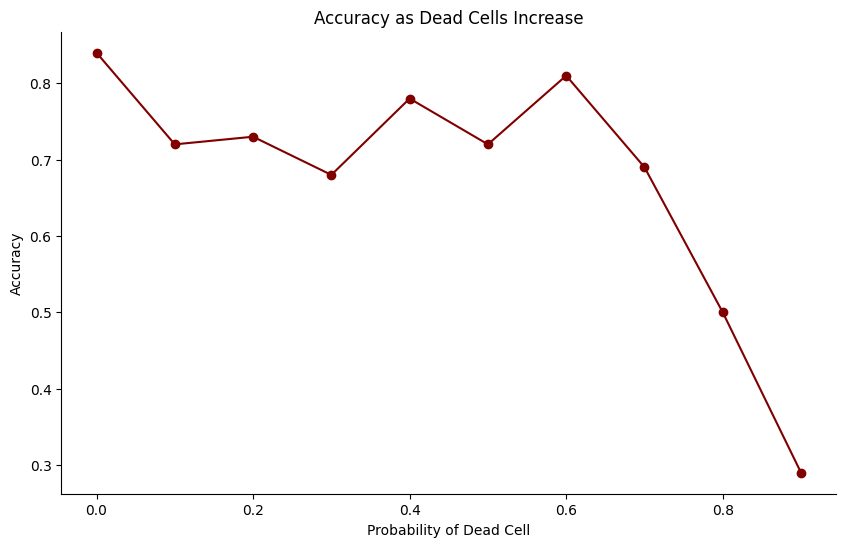

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot([PROB_DEAD_CELL_STEP * i for i in range(NUM_EYES)], accuracies, 'o-', color='maroon')
ax.set_xlabel('Probability of Dead Cell')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy as Dead Cells Increase')
sns.despine(ax=ax)